# Tweet Sentiment Classification with Fine-Tuned GPT-2
*A transformer-based solution for decoding mood on social media*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project runs in Google Colab to make use of the free GPU support.
Start by mounting Google Drive to access the project files. If this is your first time running the project, clone the repository. Otherwise, pull the latest changes to stay up to date.
Once that’s done, run the setup script to install any dependencies and make sure the environment is ready to go.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# If the repo doesn't exist in Google Drive, clone it
# !git clone https://github.com/herrerovir/gpt2-tweet-sentiment

# If the repo does exist:
%cd /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
!git pull

/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
Already up to date.


In [3]:
# Import config file
import config
config.setup(subdir = "notebooks")
from config import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/notebooks


In [4]:
# Install dependencies
!pip install evaluate

import numpy as np
from datasets import load_from_disk, DatasetDict
from transformers import (
    GPT2Tokenizer,
    GPT2Config,
    GPT2ForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TextClassificationPipeline,
    set_seed
)
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from collections import Counter
import re

# Set random seed for reproducibility
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00


## Data Loading

In [5]:
# Load preprocessed Hugging Face dataset
dataset: DatasetDict = load_from_disk(RAW_DIR / "HF-dataset-tweet-sentiment-extraction")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3534
    })
})

## Data Cleaning

In [6]:
print("First 5 entries from the training data:")
for i in range(5):
    print(f"\n{i+1}. {dataset['train'][i]['text']}")

First 5 entries from the training data:

1.  I`d have responded, if I were going

2.  Sooo SAD I will miss you here in San Diego!!!

3. my boss is bullying me...

4.  what interview! leave me alone

5.  Sons of ****, why couldn`t they put them on the releases we already bought


### Dataset split and sizes

In [7]:
print("Dataset splits and sizes:\n")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits and sizes:

- train: 27481 samples
- test: 3534 samples


### Null Values

In [8]:
print("Null values in the dataset:\n")
for split in dataset:
    texts = dataset[split]["text"]
    empty_count = sum(1 for x in texts if x is None or (isinstance(x, str) and x.strip() == ""))
    print(f"- {split}: {empty_count} null values")


Null values in the dataset:

- train: 1 null values
- test: 0 null values


In [9]:
def is_valid(example):
    """
    Checks whether a text example is valid for further processing.

    An example is considered valid if:
    - The 'text' field is not None.
    - The 'text' field is not an empty string or whitespace-only.

    Parameters:
        example (dict): A single data sample, expected to have a 'text' key.

    Returns:
        bool: True if the example has a valid, non-empty 'text' field; False otherwise.
    """
    return example["text"] is not None and example["text"].strip() != ""

dataset = dataset.filter(is_valid)

In [10]:
print("Dataset splits sizes after removing null values:")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits sizes after removing null values:
- train: 27480 samples
- test: 3534 samples


### Duplicate Values

In [11]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 0 duplicates
- test: 0 duplicates


### Remove URLs, Mentions and White Spaces

In [12]:
def clean_tweet(text):
    """
    Cleans a tweet for sentiment classification:

    Steps performed:
    - Removes URLs (e.g., http://..., https://..., www...)
    - Removes user mentions (e.g., @username)
    - Removes extra whitespace (multiple spaces, leading/trailing spaces)

    Parameters:
        text (str): The tweet text to clean. Can be None.

    Returns:
        str: The cleaned tweet text. If input is None, returns an empty string.
    """
    if text is None:
        return ""

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove extra spaces and strip leading/trailing whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [13]:
def clean_example(example):
    example["text"] = clean_tweet(example["text"])
    return example

dataset = dataset.map(clean_example)

Checking for duplicates after cleaning.

In [14]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 45 duplicates
- test: 1 duplicates


In [15]:
for split in dataset:
    # Convert to pandas DataFrame
    df = dataset[split].to_pandas()
    # Drop duplicates
    df = df.drop_duplicates(subset = ["text"])
    # Convert back to Dataset
    dataset[split] = dataset[split].from_pandas(df)


### Label Distribution

In [16]:
print("Dataset Label distribution:")
for split in dataset:
    labels = dataset[split]["label"]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{split.title()} Set:")
    for label, count in sorted(counts.items()):
        print(f"  Label {label}: {count} ({count/total*100:.2f}%)")

Dataset Label distribution:

Train Set:
  Label 0: 7773 (28.33%)
  Label 1: 11103 (40.47%)
  Label 2: 8559 (31.20%)

Test Set:
  Label 0: 1000 (28.30%)
  Label 1: 1430 (40.48%)
  Label 2: 1103 (31.22%)


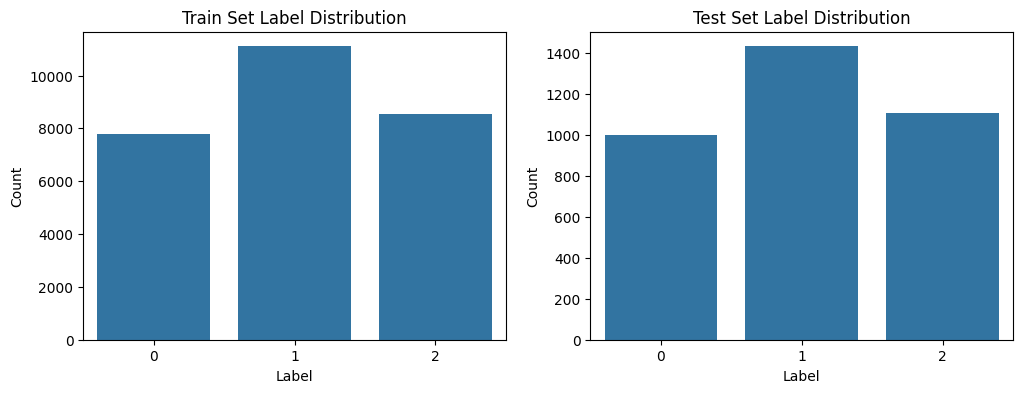

In [17]:
# Plot label distribution for each split
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

for idx, split in enumerate(dataset):
    # Convert the split to a pandas DataFrame
    df = dataset[split].to_pandas()
    #  Calculate label distribution
    label_counts = df["label"].value_counts().sort_index()

    # Plot
    sns.barplot(x = label_counts.index.astype(str), y = label_counts.values, ax = axes[idx])
    axes[idx].set_title(f"{split.title()} Set Label Distribution")
    axes[idx].set_xlabel("Label")
    axes[idx].set_ylabel("Count")